# Santa 2025 – Christmas Tree Packing Challenge

#### **Solved by:** Ramakrushna M.

[![GitHub Repo](https://img.shields.io/badge/GitHub%20Repo-000000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Ramakm/ai-hands-on)

[![X](https://img.shields.io/badge/X-000000?style=for-the-badge&logo=x&logoColor=white)](https://x.com/techwith_ram)
[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Ramakm)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/ramakrushnamohapatra/)
[![Instagram](https://img.shields.io/badge/Instagram-E4405F?style=for-the-badge&logo=instagram&logoColor=white)](https://instagram.com/techwith.ram)


## Objective

The objective of this challenge is to determine the **smallest possible square box** that can contain a given number of identical Christmas tree toys.

For each configuration containing **n trees** (1 ≤ n ≤ 200), all trees must be positioned and rotated in two dimensions such that:

- No trees overlap
- All trees fit inside a square
- The side length of the square is minimized

## Problem Statement

### Input
- **Each Christmas tree** is a fixed 2D shape
- **Trees may be rotated**, but their shape remains unchanged
- **Each tree placement** is defined by:
  - `x` and `y` coordinates
  - `deg`: the rotation angle in degrees
  - **Position reference**: (x, y) corresponds to the center of the top of the tree trunk

### Constraint
- **For every value of n from 1 to 200**, a valid configuration must be provided that satisfies all constraints

## Evaluation Metric

### Scoring Formula

Submissions are evaluated based on the **area efficiency** of the packing.

For a configuration with **n trees**:

**Bounding Square**: Let $s_n$ be the side length of the smallest square that contains all trees.

**Score for configuration n**:
$$\text{Score}_n = \frac{s_n^2}{n}$$

This metric penalizes unused space and rewards compact arrangements.

### Final Leaderboard Score

The final leaderboard score is computed as the sum across all configurations:

$$\text{Final Score} = \sum_{n=1}^{200} \frac{s_n^2}{n}$$

**Lower scores are better.** Each configuration contributes to the final score, with configurations containing more trees weighted less heavily (divided by n).

In [1]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.0.6


In [2]:
import math
import os
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal - high precision for geometric accuracy
getcontext().prec = 25
scale_factor = Decimal('1e15')  # Scale factor to work with integer operations

# Build Submission Index

The submission format requires a specific index for each tree:
- Format: `{n:03d}_{t}` where n is number of trees and t is tree index (0 to n-1)
- Example: `001_0` (first tree in 1-tree configuration), `200_199` (200th tree in 200-tree configuration)

Total trees needed: $\sum_{n=1}^{200} n = \frac{200 \times 201}{2} = 20,100$ trees

In [3]:
# Build the index of the submission, in the format: <trees_in_problem>_<tree_index>
index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]
print(f"Total submission indices: {len(index)}")
print(f"First few: {index[:5]}")
print(f"Last few: {index[-5:]}")

Total submission indices: 20100
First few: ['001_0', '002_0', '002_1', '003_0', '003_1']
Last few: ['200_195', '200_196', '200_197', '200_198', '200_199']


# Christmas Tree Geometry

Each tree has a fixed 2D shape consisting of:
- **3 tiers** (top, middle, bottom) representing the tree canopy
- **1 trunk** at the bottom
- **16 vertices** defining the outline

### Tree Dimensions (in normalized units)
- Trunk width: 0.15, height: 0.2
- Base tier width: 0.7
- Middle tier width: 0.4  
- Top tier width: 0.25
- Total height: 0.8 (canopy) + 0.2 (trunk) = 1.0

The coordinates are scaled by $10^{15}$ for precision in Shapely's geometric operations.

In [4]:
class ChristmasTree:
    """
    Represents a single, rotatable Christmas tree of a fixed size.
    
    A tree is defined by:
    - center_x, center_y: position of the tree center (top of trunk)
    - angle: rotation in degrees
    - polygon: Shapely Polygon for collision detection
    """

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        # Tree dimensions (all in normalized units)
        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')      # Bottom tier width
        mid_w = Decimal('0.4')       # Middle tier width
        top_w = Decimal('0.25')      # Top tier width
        tip_y = Decimal('0.8')       # Tree tip Y position
        tier_1_y = Decimal('0.5')    # Top tier Y position
        tier_2_y = Decimal('0.25')   # Middle tier Y position
        base_y = Decimal('0.0')      # Base Y position
        trunk_bottom_y = -trunk_h    # Trunk bottom

        # Define tree outline as 16 vertices (polygon)
        # Starting from the tip and going around the outline clockwise
        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        
        # Apply rotation around origin, then translate to final position
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

# Weighted Angle Distribution

The baseline uses a clever trick: instead of uniform random angles, it weights angles to prefer corner placements.

**Key insight**: `abs(sin(2*angle))` is maximized at 45°, 135°, 225°, 315° (the diagonal corners).

This encourages trees to pack in corners where they can be arranged more efficiently, resulting in less "round" packing patterns.

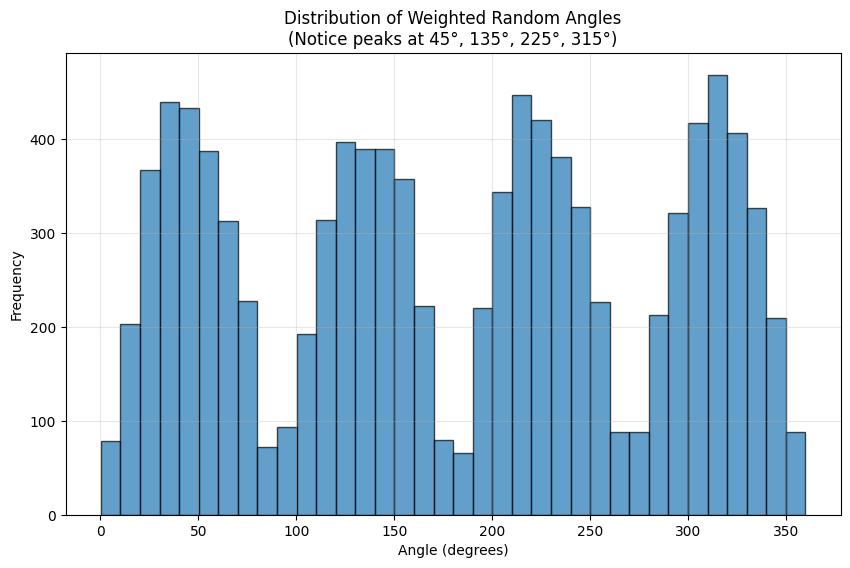

In [5]:
def generate_weighted_angle():
    """
    Generates a random angle with a distribution weighted by abs(sin(2*angle)).
    
    This ensures more trees are placed in corner directions (45°, 135°, etc.)
    rather than uniformly, leading to more compact, less-circular packing.
    
    Returns:
        float: Angle in radians between 0 and 2π
    """
    while True:
        angle = random.uniform(0, 2 * math.pi)
        # Accept angle with probability = abs(sin(2*angle))
        if random.uniform(0, 1) < abs(math.sin(2 * angle)):
            return angle

# Visualize the distribution
angles = [generate_weighted_angle() for _ in range(10000)]
plt.figure(figsize=(10, 6))
plt.hist([math.degrees(a) for a in angles], bins=36, edgecolor='black', alpha=0.7)
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Weighted Random Angles\n(Notice peaks at 45°, 135°, 225°, 315°)')
plt.grid(alpha=0.3)
plt.show()

# Greedy Incremental Placement Algorithm

This is the core algorithm from the baseline. For each n+1 configuration:

1. **Keep previous trees** - All n trees from the n-tree solution are preserved
2. **Add one new tree** - Try to place it optimally by:
   - **Multiple attempts** (10 random angles) and keep the best placement
   - **Radial search**: Start at distance 20 from center at a weighted random angle
   - **Move closer**: Reduce distance in steps of 0.5 until collision detected
   - **Back off**: Increase distance in steps of 0.05 until collision-free
   - **Collision detection**: Use Shapely's STRtree spatial index for efficiency

3. **Compute bounding square** - Find the smallest square containing all trees

In [6]:
def initialize_trees(num_trees, existing_trees=None):
    """
    Greedy incremental tree placement algorithm.
    
    For n+1 trees, this:
    1. Keeps all n trees from previous solution (existing_trees)
    2. Adds 1 new tree by trying 10 random placements
    3. For each attempt, does radial search from distance 20 toward center
    4. Uses collision detection to find valid placement
    
    Args:
        num_trees: Target number of trees to place
        existing_trees: List of ChristmasTree objects from smaller configuration
        
    Returns:
        tuple: (list of placed trees, side_length of bounding square)
    """
    if num_trees == 0:
        return [], Decimal('0')

    if existing_trees is None:
        placed_trees = []
    else:
        placed_trees = list(existing_trees)

    num_to_add = num_trees - len(placed_trees)

    if num_to_add > 0:
        # Create trees with random rotations for the new ones
        unplaced_trees = [
            ChristmasTree(angle=random.uniform(0, 360)) for _ in range(num_to_add)]
        
        # Place first tree at origin if starting from scratch
        if not placed_trees:
            placed_trees.append(unplaced_trees.pop(0))

        # Place remaining trees using greedy radial search
        for tree_to_place in unplaced_trees:
            placed_polygons = [p.polygon for p in placed_trees]
            tree_index = STRtree(placed_polygons)  # Spatial index for fast collision lookup

            best_px = None
            best_py = None
            min_radius = Decimal('Infinity')

            # Try 10 random starting angles and keep the best one
            for attempt in range(10):
                # Random direction from center (weighted toward corners)
                angle = generate_weighted_angle()
                vx = Decimal(str(math.cos(angle)))
                vy = Decimal(str(math.sin(angle)))

                # Start from distance 20, move toward center
                radius = Decimal('20.0')
                step_in = Decimal('0.5')

                collision_found = False
                while radius >= 0:
                    px = radius * vx
                    py = radius * vy

                    # Create candidate position and check collision
                    candidate_poly = affinity.translate(
                        tree_to_place.polygon,
                        xoff=float(px * scale_factor),
                        yoff=float(py * scale_factor))

                    # Query spatial index for nearby polygons
                    possible_indices = tree_index.query(candidate_poly)
                    
                    # Check for actual collisions (not just touching)
                    if any((candidate_poly.intersects(placed_polygons[i]) and not
                            candidate_poly.touches(placed_polygons[i]))
                           for i in possible_indices):
                        collision_found = True
                        break
                    radius -= step_in

                # If collision found, back off until clear
                if collision_found:
                    step_out = Decimal('0.05')
                    while True:
                        radius += step_out
                        px = radius * vx
                        py = radius * vy

                        candidate_poly = affinity.translate(
                            tree_to_place.polygon,
                            xoff=float(px * scale_factor),
                            yoff=float(py * scale_factor))

                        possible_indices = tree_index.query(candidate_poly)
                        if not any((candidate_poly.intersects(placed_polygons[i]) and not
                                   candidate_poly.touches(placed_polygons[i]))
                                   for i in possible_indices):
                            break
                else:
                    # No collision even at center - place at origin
                    radius = Decimal('0')
                    px = Decimal('0')
                    py = Decimal('0')

                # Keep the placement closest to center (smallest radius)
                if radius < min_radius:
                    min_radius = radius
                    best_px = px
                    best_py = py

            # Apply best placement to this tree
            tree_to_place.center_x = best_px
            tree_to_place.center_y = best_py
            tree_to_place.polygon = affinity.translate(
                tree_to_place.polygon,
                xoff=float(tree_to_place.center_x * scale_factor),
                yoff=float(tree_to_place.center_y * scale_factor),
            )
            placed_trees.append(tree_to_place)

    # Compute bounding square
    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # Force square by using larger dimension
    side_length = max(width, height)

    return placed_trees, side_length

# Visualization Function

The plotting function helps us understand how well the packing is working:
- Each tree is colored differently for visibility
- The red dashed square shows the bounding box
- We can see gaps and overlaps at a glance

In [7]:
def plot_results(side_length, placed_trees, num_trees):
    """
    Visualizes the tree packing configuration.
    
    Args:
        side_length: Side length of bounding square
        placed_trees: List of ChristmasTree objects
        num_trees: Number of trees (for title)
    """
    _, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.viridis([i / num_trees for i in range(num_trees)])

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    # Plot each tree
    for i, tree in enumerate(placed_trees):
        # Rescale from scale_factor back to original coordinates
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i])
        ax.fill(x, y, alpha=0.5, color=colors[i])

    # Get bounds and compute bounding square
    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny

    # Position square to center the content
    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='red',
        linewidth=2,
        linestyle='--',
    )
    ax.add_patch(bounding_square)

    # Set plot limits with padding
    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding))))
    ax.set_ylim(float(square_y - Decimal(str(padding))),
                float(square_y + side_length + Decimal(str(padding))))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.title(f'{num_trees} Trees: {side_length:.12f}')
    plt.show()
    plt.close()

# Run Baseline Algorithm

This runs the greedy incremental placement algorithm for all 200 configurations and generates the sample submission CSV.

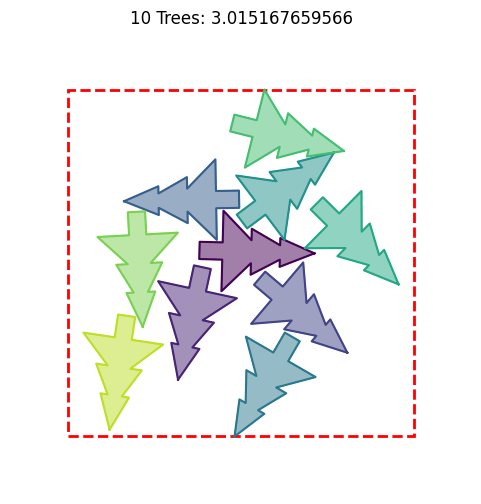

n=10: side_length=3.015168, score=0.909124


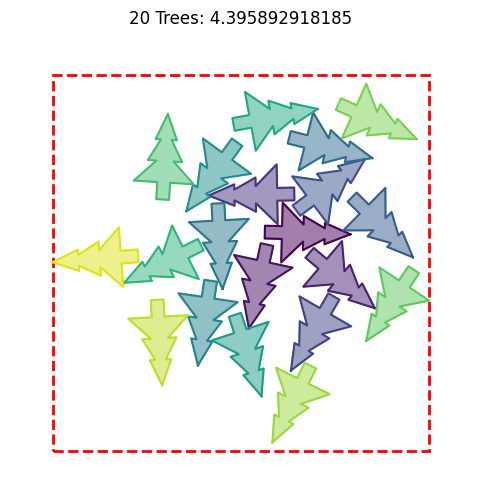

n=20: side_length=4.395893, score=0.966194


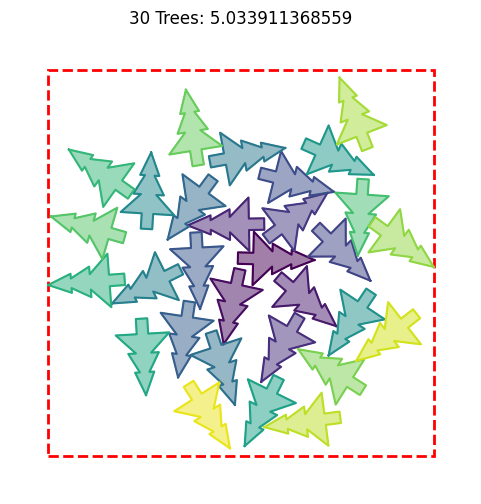

n=30: side_length=5.033911, score=0.844675


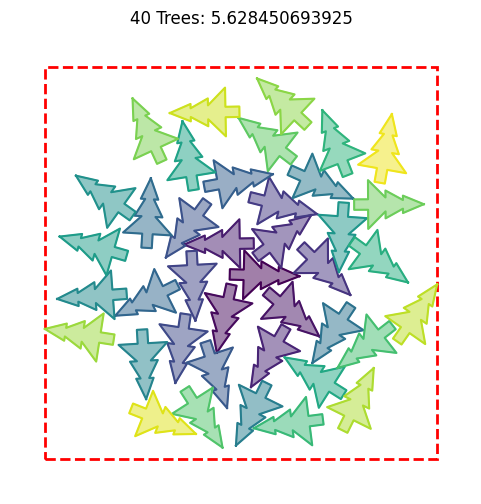

n=40: side_length=5.628451, score=0.791986


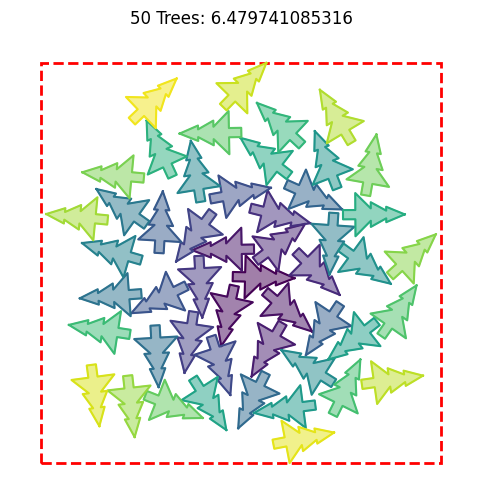

n=50: side_length=6.479741, score=0.839741


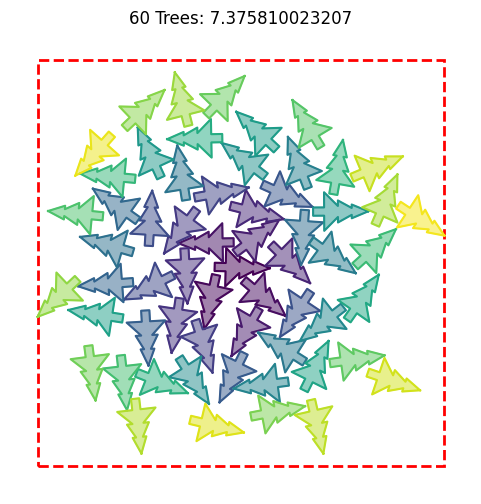

n=60: side_length=7.375810, score=0.906710


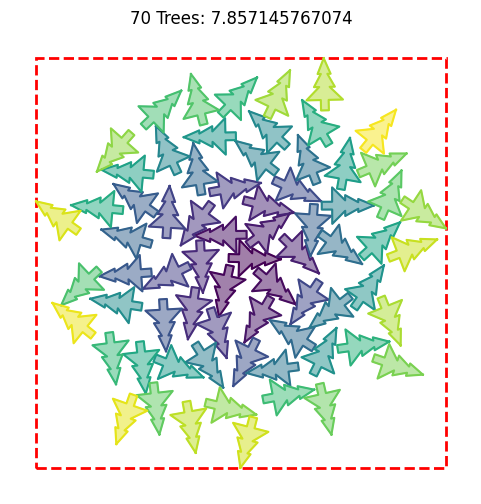

n=70: side_length=7.857146, score=0.881925


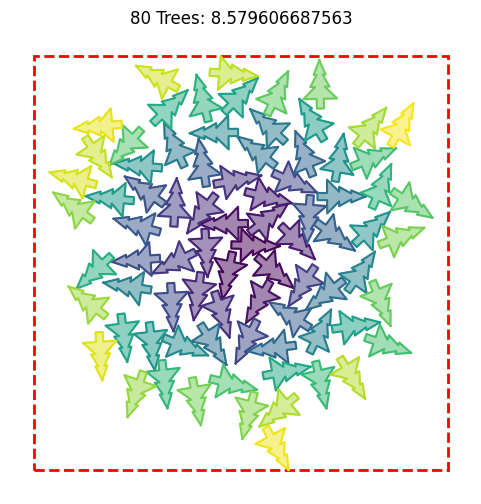

n=80: side_length=8.579607, score=0.920121


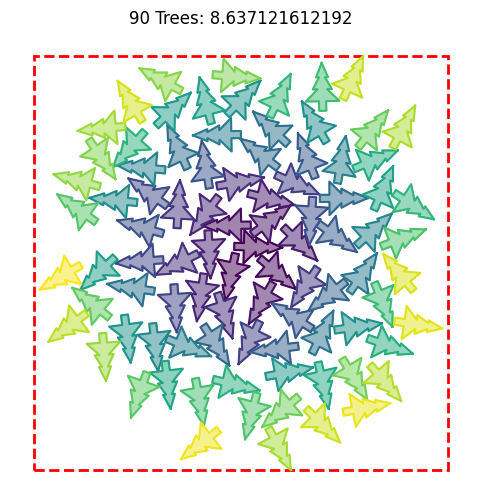

n=90: side_length=8.637122, score=0.828887


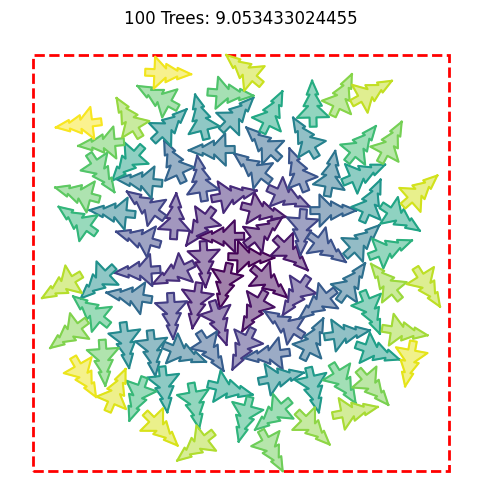

n=100: side_length=9.053433, score=0.819646


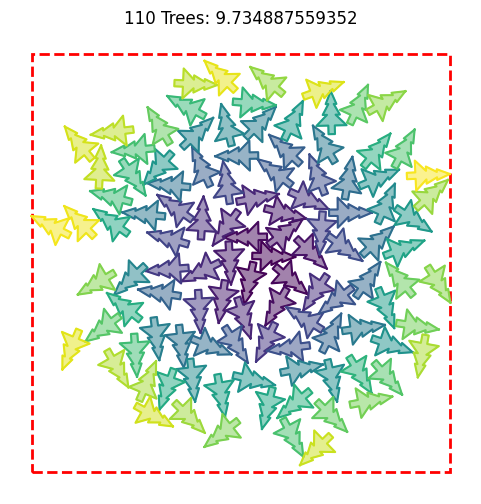

n=110: side_length=9.734888, score=0.861528


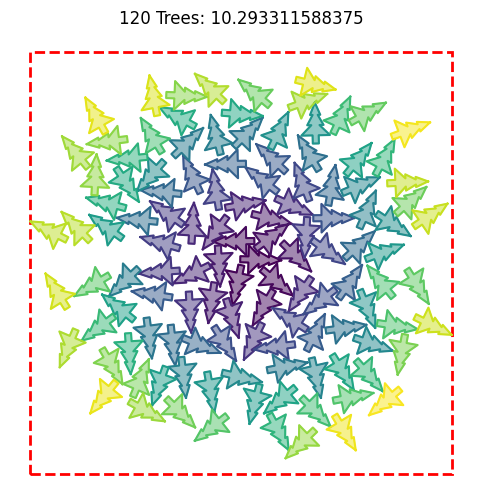

n=120: side_length=10.293312, score=0.882936


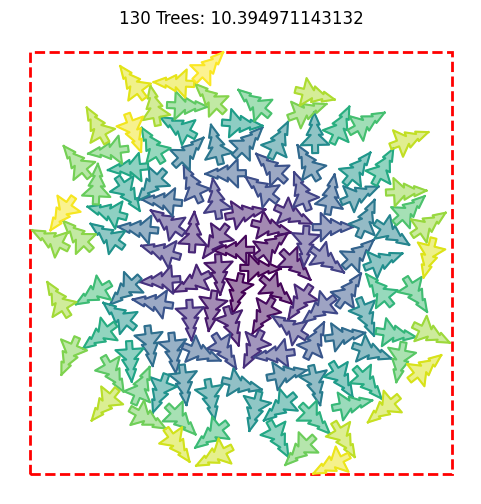

n=130: side_length=10.394971, score=0.831196


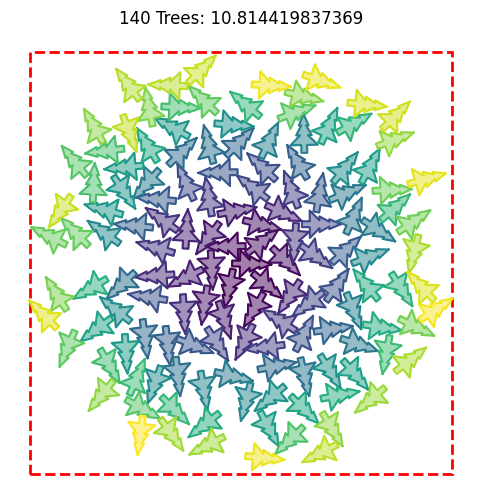

n=140: side_length=10.814420, score=0.835369


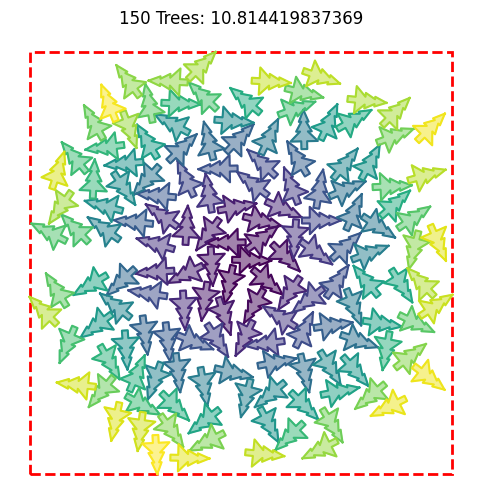

n=150: side_length=10.814420, score=0.779678


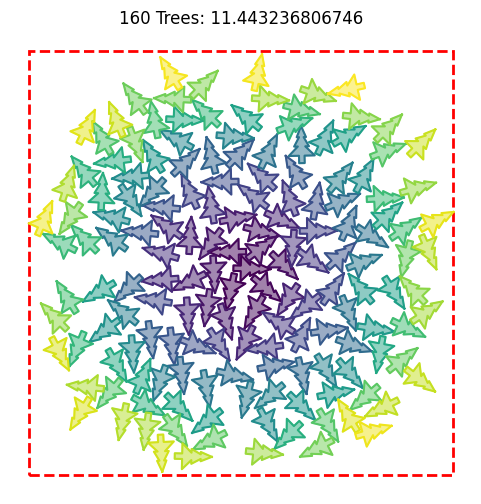

n=160: side_length=11.443237, score=0.818423


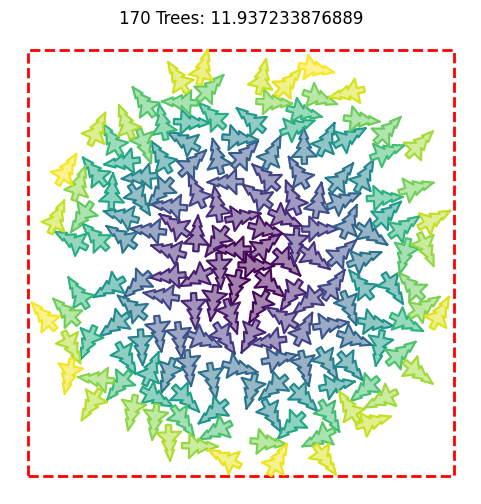

n=170: side_length=11.937234, score=0.838221


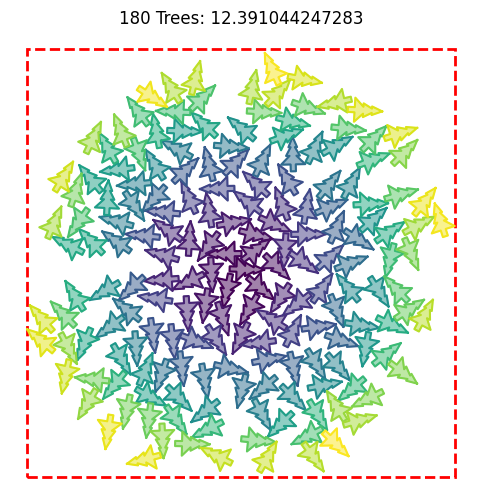

n=180: side_length=12.391044, score=0.852989


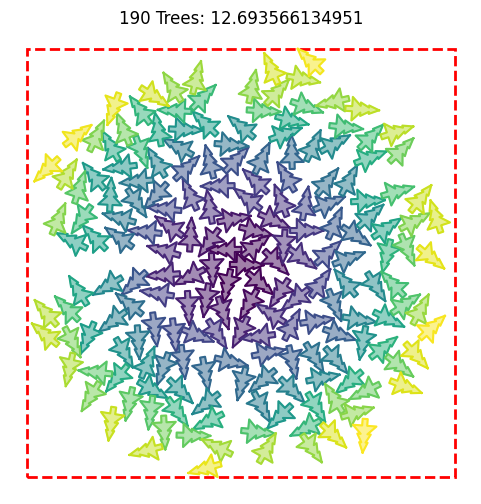

n=190: side_length=12.693566, score=0.848035


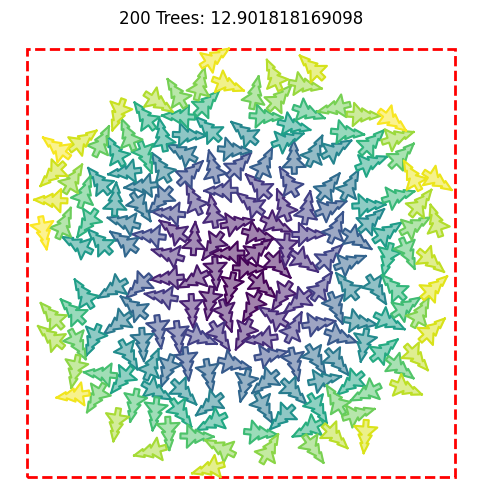

n=200: side_length=12.901818, score=0.832285

Submission saved to sample_submission.csv
Shape: (20100, 3)
                x           y          deg
id                                        
001_0        s0.0        s0.0  s268.542784
002_0        s0.0        s0.0  s268.542784
002_1  s-0.216664  s-0.336239  s167.786133
003_0        s0.0        s0.0  s268.542784
003_1  s-0.216664  s-0.336239  s167.786133


In [8]:
# Run the greedy algorithm for all configurations
tree_data = []
current_placed_trees = []

for n in range(200):
    # Build solution for n+1 trees
    current_placed_trees, side = initialize_trees(n+1, existing_trees=current_placed_trees)
    
    # Visualize every 10 configurations
    if (n+1) % 10 == 0:
        plot_results(side, current_placed_trees, n+1)
        print(f"n={n+1}: side_length={side:.6f}, score={side**2/(n+1):.6f}")
    
    # Collect data for submission
    for tree in current_placed_trees:
        tree_data.append([tree.center_x, tree.center_y, tree.angle])

# Create submission DataFrame
cols = ['x', 'y', 'deg']
submission = pd.DataFrame(
    index=index, columns=cols, data=tree_data).rename_axis('id')

# Format: round to 6 decimals
for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)

# Convert to string with 's' prefix as required
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')

# Save to CSV
submission.to_csv('sample_submission.csv')
print(f"\nSubmission saved to sample_submission.csv")
print(f"Shape: {submission.shape}")
print(submission.head())

In [10]:
sample = pd.read_csv('sample_submission.csv')
sample.head()

id           x           y          deg
0  001_0        s0.0        s0.0  s268.542784
1  002_0        s0.0        s0.0  s268.542784
2  002_1  s-0.216664  s-0.336239  s167.786133
3  003_0        s0.0        s0.0  s268.542784
4  003_1  s-0.216664  s-0.336239  s167.786133